<a href="https://colab.research.google.com/github/hyeonjun/AlphaZero/blob/master/4_2_Policy_Gradient__maze_game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 정책 경사법을 활용한 미로 게임 풀기
정책에 따라 행동하면서 성공 시의 행동은 중요한 것으로 판단하고, 그 행동을 많이 할 수 있도록 정책을 갱신하는 방법을 '정책 경사법'이라고 부른다.

에이전트가 상하좌우로 이동해 골인 지점(우측 하단)까지 도착하는 것이 목적이다.

* 정책 경사법을 활용한 미로 게임에서의 강화 학습 요소

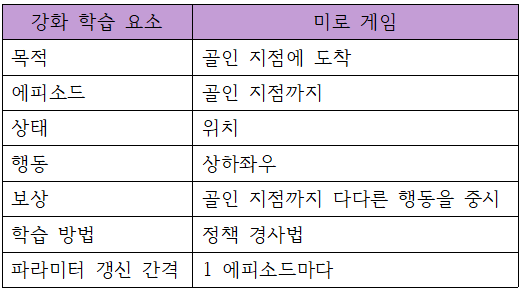

정책 경사법을 활용한 미로 게임의 강화 학습 사이클. 정책 반복법에서 정책을 갱신한다.

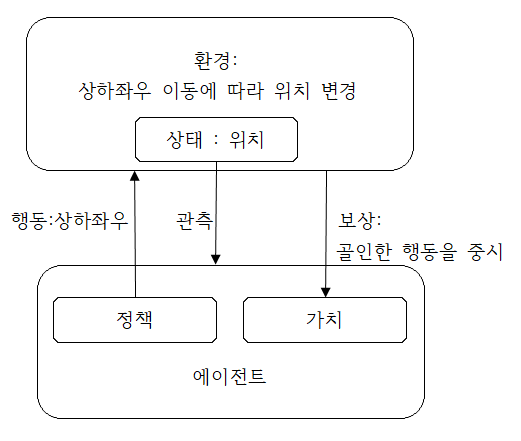

# 정책 경사법 학습순서
학습에 따라 정책(θ)을 최적화한다.

1. 파라미터 θ 준비
2. 파라미터 θ를 정책으로 변환
3. 정책에 따라 골인 지점에 이를 때까지 행동 반복
4. 성공한 행동을 많이 받아들이도록 파라미터 θ를 변경
5. 정책 변화량이 임곗값 이하가 될 때까지 2~4단계 반복

* 정책

정책은 '특정한 상태에서 특정한 행동을 할 확률'을 의미. 정책은 주로 함수나 뉴럴 네트워크로 표현하지만, 여기서는 가장 간단한 '테이블 형식'으로 표현한다. 상태별로 행동을 선택할 확률을 '상태 수 * 행동 수' 배열로 저장한다.

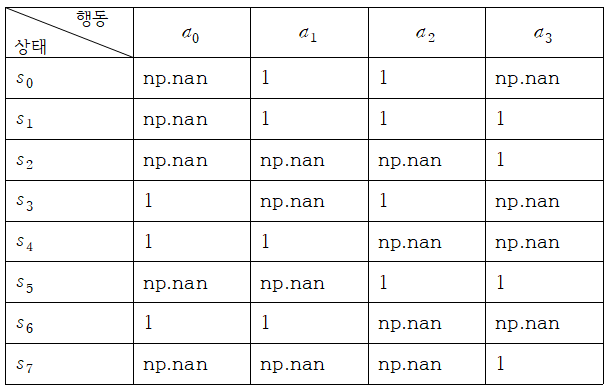

* 파라미터 θ

파라미터 θ는 정책으로 변환되는 값. 딥러닝에서 가중치 파라미터에 해당한다. 이 역시 '상태 수 * 행동 수' 배열에 저장한다.

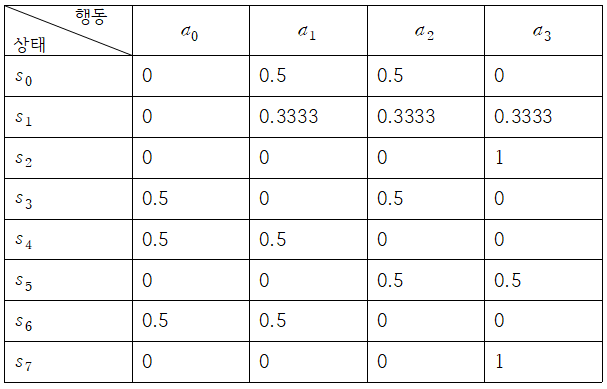

정책 경사법에서는 1 에피소드 훈련 후 정책(θ)을 반복적으로 갱신하면서 정책을 최적화해 나간다.


In [ ]:
# import package
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation # matplotlib에서 애니메이션을 수행하는 함수인 animation()
from IPython.display import HTML # Google Colab에 HTML을 삽입하는 함수인 HTML()

# 미로 생성
그래프 표시 라이브러리인 matplotlib을 사용해 미로를 생성한다.

plt.figure()로 그래프를 생성한다. 인수는 폭과 높이. 인치 단위(2.54cm)로 지정한다. 반환값 'Figure'는 이후 애니메이션을 할 때 사용한다.

미로의 벽은 plt.plot()을 사용해 선으로 그리고, 숫자는 plt.text()로 텍스트로 표시하며, 원은 plt.plot()의 mark를 사용해 마크를 표시한다. 원의 plt.plot()의 반환값은 Line2D 배열로 이 역시 이후 애니메이션을 할 때 사용한다.

그래프 주변에는 축과 테두리가 표시되는데, 축을 표시하지 않기 위해 plt.tick_params(), 테두리를 표시하지 않기 위해 plt.box()를 사용한다.

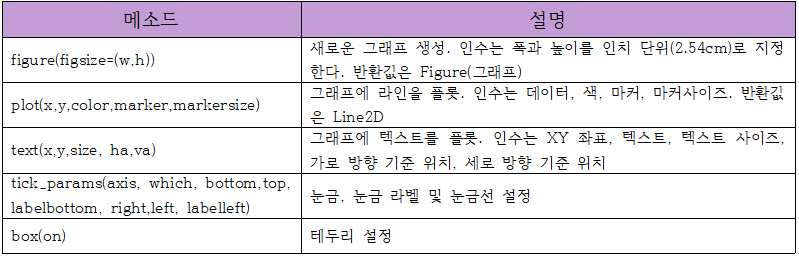

matplotlib의 색상은 '#ff0000(빨강)','#000000(검정)'과 같이 HTML에서 이용하는 16진수로 지정할 수 있으며, 다음의 색상 상수도 사용할 수 있다.

- b : 파랑,  g : 초록,  r : 빨강,  c : 사이언
- m : 마젠타,  y : 노랑,  k : 검정,  w : 하양


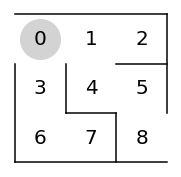

In [ ]:
# 미로 생성
fig = plt.figure(figsize = (3,3))

# 벽
plt.plot([0,3], [3,3], color='k')
plt.plot([0,3], [0,0], color='k')
plt.plot([0,0], [0,2], color='k')
plt.plot([3,3], [1,3], color='k')
plt.plot([1,1], [1,2], color='k')
plt.plot([2,3], [2,2], color='k')
plt.plot([2,1], [1,1], color='k')
plt.plot([2,2], [0,1], color='k')

# 숫자
for i in range(3):
  for j in range(3):
    plt.text(0.5 + i, 2.5 - j, str(i+j*3), size=20, ha='center', va='center')

# 원
circle, = plt.plot([0.5],[2.5], marker='o', color='#d3d3d3', markersize=40)

# 눈금 및 배경 숨김
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=False, right=False, left=False, labelleft=False)
plt.box(False)

# 파라미터 θ의 초기값 준비
학습 전에는 올바른 파라미터 θ(가중치 파라미터)를 알지 못하므로 이동할 수 있는 방향은 1, 이동할 수 없는 방향은 'np.nan(Numpy에서의 결손값)'으로 초기화한다.

가장 위의 행은 0번 위치에서의 행동으로 왼쪽부터 '상, 우, 하, 좌' 방향을 의미한다. 매스 8은 골인 지점이므로 초기값이 존재하지 않음.

In [ ]:
# 파라미터 θ의 초기값 준비
theta_0 = np.array([
                    [np.nan, 1, 1, np.nan], # 0 상, 우, 하, 좌
                    [np.nan, 1,1,1], # 1
                    [np.nan, np.nan, np.nan, 1], # 2
                    [1, np.nan, 1, np.nan], # 3
                    [1, 1, np.nan, np.nan], # 4
                    [np.nan, np.nan, 1,1], # 5
                    [1, 1, np.nan, np.nan], # 6
                    [np.nan, np.nan, np.nan, 1] # 7
                    ])

# 파라미터 θ의 정책으로 변한
파라미터 θ를 정책으로 변환하는 경우 정책 경사법에서는 '소프트맥스 함수'를 이용한다.
소프트맥스 함수는 여러 값의 합계가 1이 되도록 해당 값들을 0~1사이의 실수값으로 변경한다.

[np.nan, 1, 1, np.nan] -> [0, 0.5, 0.5, 0]

이 함수는 딥러닝의 분류 출력 레이어에서도 이용된다. 단순 나눗셈과 비교해 파라미터 θ가 음의 값이라 하더라도 계산할 수 있다는 이점이 있다.

* 소프트맥스 함수의 수식
소프트맥스 함수 = 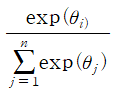

image.png: 어떤 상태에서 어떤 행동을 취할 확률 리스트

image.png: 어떤 상태에서 어떤 행동을 취할 확률

n: 행동 수

exp(): ex를 반환하는 함수(e는 네이피어 수)

In [ ]:
# 파라미터 θ를 정책으로 변환
def get_pi(theta):
  # 소프트맥스 함수로 변환
  [m, n] = theta.shape
  pi = np.zeros((m,n))
  exp_theta = np.exp(theta)

  for i in range(0,m):
    pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])

  pi = np.nan_to_num(pi)
  return pi

In [ ]:
# 파라미터 θ의 초기값을 정책으로 변환
# 한 열의 합은 1
pi_0 = get_pi(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.         0.         0.         1.        ]
 [0.5        0.         0.5        0.        ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.5        0.5       ]
 [0.5        0.5        0.         0.        ]
 [0.         0.         0.         1.        ]]


# 정책에 따라 행동 얻기
정책에 따라 행동(0: 상, 1: 우, 2: 하, 3: 좌)을 얻는 함수를 생성한다. np.random.choice()는 인수 p의 확률 분포에 따라 배열의 엘리먼트를 무작위로 반환하는 함수다. 값이 [0,1,2,3]이고, p가 [0., 0.5, 0.5, 0.]인 경우에는 50% 확률로 1 또는 2를 반환한다.

이번에는 p에 임의 상태의 정책, 즉 임의의 매스에서의 확률 분포를 지정한다.

In [ ]:
# 정책에 따라 행동 얻기
def get_a(pi, s):
  # 정책의 확률에 따라 행동 반환
  return np.random.choice([0,1,2,3], p=pi[s])

In [ ]:
# 행동에 따라 다음 상태 얻기
# 행동에 따라 다음 상태를 얻는 함수를 생성한다. 3 * 3 사이즈의 미로이므로 좌우 이동은 +-1, 상하 이동은 +-3으로 한다.
def get_s_next(s, a):
  if a == 0: # 상
    return s-3
  elif a == 1: # 우
    return s+1
  elif a == 2: # 하
    return s+3
  elif a == 3: # 좌
    return s-1

In [ ]:
# 1 에피소드 실행하고 이력을 얻는다. 이력은 [상태, 행동]의 리스트
def play(pi):
  s = 0 # 상태
  s_a_history = [[0, np.nan]] # 상태와 행동 이력

  # 에피소드 종료 시까지 반복
  while True:
    # 정책에 따라 행동 얻기
    a = get_a(pi, s)

    # 행동에 따라 다음 상태 얻기
    s_next = get_s_next(s, a)

    # 이력 갱신
    s_a_history[-1][1] = a
    s_a_history.append([s_next, np.nan])

    # 종료 판전
    if s_next == 8:
      break
    else:
      s = s_next
  return s_a_history

In [ ]:
# 1 에피소드 실행 및 이력 확인
# 1 에피소드 실행 결과를 확인. 골인 지점까지 어떤 경로로 얼마만큼의 스텝이 걸렸는지 알 수 있다. 실행하는 동안 경로는 계속 변한다.
s_a_history = play(pi_0)
print(s_a_history)
print('1 에피소드의 스텝 수: {}'.format(len(s_a_history)+1))

[[0, 2], [3, 2], [6, 0], [3, 0], [0, 2], [3, 2], [6, 1], [7, 3], [6, 0], [3, 0], [0, 1], [1, 3], [0, 2], [3, 2], [6, 0], [3, 0], [0, 2], [3, 0], [0, 2], [3, 0], [0, 2], [3, 0], [0, 1], [1, 3], [0, 1], [1, 1], [2, 3], [1, 2], [4, 1], [5, 3], [4, 0], [1, 1], [2, 3], [1, 2], [4, 1], [5, 3], [4, 0], [1, 2], [4, 1], [5, 2], [8, nan]]
1 에피소드의 스텝 수: 42


# 파라미터 θ 갱신
정책은 현재 상태에 맞춰 다음 행동을 결정하는 전략이다. 정책 경사법에서 정책을 갱신하려면 정책 가중치 파라미터인 파라미터 θ를 직접 갱신한다.

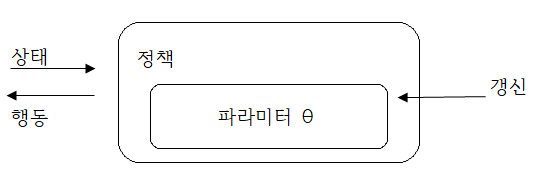

* 정책 경사법에서 파라미터 θ의 변경식

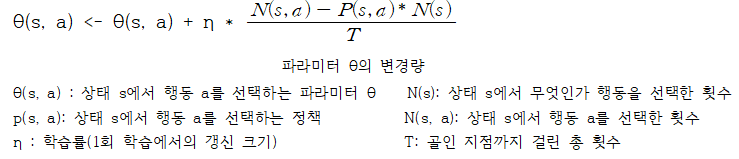

파라미터 θ에 학습 관계와 파라미터 θ의 변화량 값을 곱한 뒤 더한다. '학습률'이란 1회 학습으로 갱신된 크기다.

In [ ]:
# 파라미터 θ 갱신
def update_theta(theta, pi, s_a_history):
  eta = 0.1 # 학습 계수
  total = len(s_a_history) - 1 # 골인 지점까지 걸린 총 스텝 수
  [s_count, a_count] = theta.shape # 상태 수, 행동

  # 파라미터 θ의 변화량 계산
  delta_theta = theta.copy()
  for i in range(0, s_count):
    for j in range(0, a_count):
      if not(np.isnan(theta[i,j])):
        # 상태 s에서 행동 a를 선택한 횟수
        sa_ij = [sa for sa in s_a_history if sa == [i,j]]
        n_ij = len(sa_ij)

        # 상태 s에서 무엇인가 행동을 선택한 횟수
        sa_i = [sa for sa in s_a_history if sa[0] == i]
        n_i = len(sa_i)

        # # 파라미터 θ의 변화량
        delta_theta[i,j] = (n_ij - pi[i,j] * n_i) / total
  # 파라미터 θ 갱신
  return theta + eta * delta_theta

In [ ]:
# 에피소드를 반복해서 실행하며 학습하기
# 정책의 변화량이 임곗값 이하가 되면 종료한다.

stop_epsilon = 10 ** -4 # 역치
theta = theta_0 # 파라미터 θ
pi = pi_0 # 정책

# 에피소드를 반복해서 실행하며 학습
for episode in range(10000):
  # 1 에피소드 실행 수 이력 얻기
  s_a_history = play(pi)

  # 파라미터 θ 갱신
  theta = update_theta(theta, pi, s_a_history)

  # 정책 갱신
  pi_new = get_pi(theta)

  # 정책 변화량
  pi_delta = np.sum(np.abs(pi_new-pi))
  pi = pi_new

  # 출력
  print('episode: {}, step: {}, Policy change: {:.4f}'.format(episode, len(s_a_history)-1, pi_delta))

  # 완료 판정
  if pi_delta < stop_epsilon: # 정책 변화량이 임곗값 이하되면
    break

# 애니메이션 표시
* animate() : 애니메이션 프레임별 처리를 수행하는 함수로 인수 i는 몇 번째 프레임인지를 의미한다. Line2D에서 제공하는 circle의 set_data()로 xy좌표를 갱신한다.

* animation.FuncAnimation

애니메이션을 생성하는 클래스다. 인수로는 Figure, 애니메이션의 정기적 처리를 수행하는 함수. 최대 프레임 수, 인터벌(millsecond 단위), 반복 여부를 지정한다. FuncAnimation을 생성한 후, to_jshtml()을 사용해 HTML로 변환.




In [ ]:
# 애니메이션 정기 처리를 수행하는 함수
def animate(i):
  state = s_a_history[i][0]
  circle.set_data((state % 3) + 0.5, 2.5 - int(state /3))
  return circle

# 애니메이션 표시
anim = animation.FuncAnimation(fig, animate, frames=len(s_a_history), interval=200, repeat=False)
HTML(anim.to_jshtml())